# **Regresión linean con un dataset real**

---

##**bold text** Objetivos de aprendizaje este colab:

  • Lear un .csv a un DataFrame de Pandas

  • Examinar un dataset

  • Experimentar con distintas características al construir un modelo

  • Afinar los hiperparámetros del modelo

## El dataset

El dataset es un censo de California de 1990

In [ ]:
#@title Importamos los módulos relevantes
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# Las siguientes lineas ajustan la granularidad del "reporting".
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## Carga del archivo .csv a un DataFrame de pandas

In [ ]:
# Importamos el dataset
training_df = pd.read_csv(filepath_or_buffer = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Escalamos la etiqueta
training_df["median_house_value"] /= 1000.0

# Imprimimos las primeras lineas del DataFrame de pandas
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Al escalar el valor de la casa media (median_house_value), se pone el valor de cada casa en unidades de miles. El escalado mantendrá los valores de pérdida (loss) y las tasas de aprendizaje (learning rates) en un rango más amigable.

Aunque escalar una etiqueta no suele ser esencial, escalar características en un modelo de varias características suele ser esencial.


# Examinar el dataset

En un proyecto de machine learning es muy importante conocer tu data. Pandas tiene la función **describe()** que muestra las siguientes estadísticas de cada columna.

  • **count**, que es el número de filas (lineas) en esa columna. Idealmente, todos las columnas de count deberían de contener el mismo valor

  • **mean** y **std**, que nos muestran la media y la desviación estandar en cada columna.

  • **min** y **max**, que continen el valor mínimo y el máximo de cada columna.

  • 25%, 50%, 75%, que continen varios cuartiles.

In [ ]:
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# TAREA 1: Indetifica anomalías en el dataset

In [ ]:
#@title Anomalias encontradas

# El máximo valor de algunas cuantas columnas parace muy elevado
# comparado a otros cuartiles. Por ejemplo, en la muestra de la
# columna "total_rooms". Dados los valores de los cuartiles (25%,
# 50%, y 75%), podríamos esperar el máximo valor de 5.000 o 10.000.
# Y el resultado es de 37.937 realmente.

# Cuando vemos anomalias como estas en una columna, tenemos que tener
# mucho cuidado al usar esta columna como característica.

# Definimos funciones para construir y entrenar un modelo

  Definiremos dos funciones

  • build_model(my_learning_rate)

  • train_model(model, feature, label, epochs)

In [ ]:
#@title Difinimos las funciones que construyen y entrenan el modelo
def build_model(my_learning_rate):
  """Crear y compilar una simple regresión lineal"""
  # La mayoría de los modelos tf.keras simples son sequenciales
  model = tf.keras.models.Sequential()

  # Describimos la topografía del modelo.
  # La topografía de un simple modelo de regresión lineal
  # es un único nodo en una única capa.
  model.add(tf.keras.layers.Dense(units = 1,
                                  input_shape = (1,)))

  # Compilar la topografía del modelo en un código que TensorFlow pueda
  # ejecutara eficientemente. Configuramos el entrenamiento para minimizar
  # el error cuadrático medio (mean squared erro, en inglés).
  model.compile(optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = my_learning_rate),
                loss = "mean_squared_error",
                metrics = [tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, feature, label, epochs, batch_size):
  """Entrenar el medelo a través de alimentarlo con datos"""

  # Alimentar el modelo la característica y la etiqueta.
  # El modelo se entrenará con el número de epochs especificados.
  history = model.fit(x = df[feature],
                      y = df[label],
                      batch_size = batch_size,
                      epochs = epochs)

  # Regolectar el peso y el bias del modelo entrenado.
  trained_weight = model.get_weights()[0]
  trained_bias   = model.get_weights()[1]

  # Lista de epochs que es almacenado separadamente del resto del historial.
  epochs = history.epoch

  # Isolamos el error por cada epoch.
  hist = pd.DataFrame(history.history)

  # Para trackear la progresión del entrenamiento, vamos a sacara unas
  # capturas de la raíz del error cuadrático medio de cada epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Funciones build_model y train_model definidas.")

Funciones build_model y train_model definidas.


# Definir funciones de ploteo

In [ ]:
#@title Definimos las funciones de las gráficas
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Ploteamos el modelo entrenado de 200 entrenamientos aleatorios"""

  # Etiquetas de los ejes
  plt.xlabel(feature)
  plt.ylabel(label)

  # Creamos un scatter plot con 200 puntos aleatorios del dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Creamos una linea roja representando el modelo. La linea roja
  # empieza en las coordenadas (x0, y0) y termina en (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = random_examples[feature].max()
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c = "r")

  # Renderizamos el scatter plot y la linea roja.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Ploteamos la curva de perdida vs. los epochs."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label = "Loss")
  plt.legend()
  plt.ylim([rmse.min() * 0.97, rmse.max()])
  plt.show()

print("Funciones plot_the_model y plot_the_loss_curve definidos.")

Funciones plot_the_model y plot_the_loss_curve definidos.


# Llamada de las funciones

Una parte importante del aprendizaje automático es determinar qué características se correlacionan con la etiqueta. Por ejemplo, los modelos de predicción del valor de la vivienda en la vida real generalmente se basan en cientos de características y características sintéticas. Sin embargo, este modelo se basa en una sola característica. Por ahora, usará arbitrariamente total_rooms como esa característica.

Epoch 1/30
567/567 [==============================] - 1s 1ms/step - loss: 547447.7500 - root_mean_squared_error: 739.8971
Epoch 2/30
567/567 [==============================] - 1s 2ms/step - loss: 27686.7188 - root_mean_squared_error: 166.3933
Epoch 3/30
567/567 [==============================] - 1s 1ms/step - loss: 27130.6328 - root_mean_squared_error: 164.7138
Epoch 4/30
567/567 [==============================] - 1s 1ms/step - loss: 26272.1895 - root_mean_squared_error: 162.0870
Epoch 5/30
567/567 [==============================] - 1s 2ms/step - loss: 25575.6113 - root_mean_squared_error: 159.9238
Epoch 6/30
567/567 [==============================] - 1s 1ms/step - loss: 24807.2656 - root_mean_squared_error: 157.5032
Epoch 7/30
567/567 [==============================] - 1s 2ms/step - loss: 24375.5762 - root_mean_squared_error: 156.1268
Epoch 8/30
567/567 [==============================] - 1s 2ms/step - loss: 23559.9395 - root_mean_squared_error: 153.4925
Epoch 9/30
567/567 [===========

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


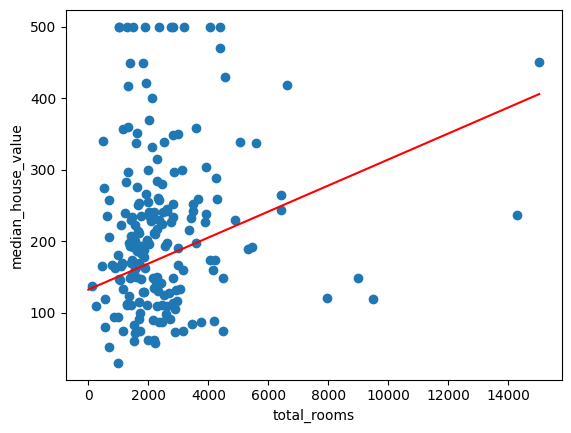

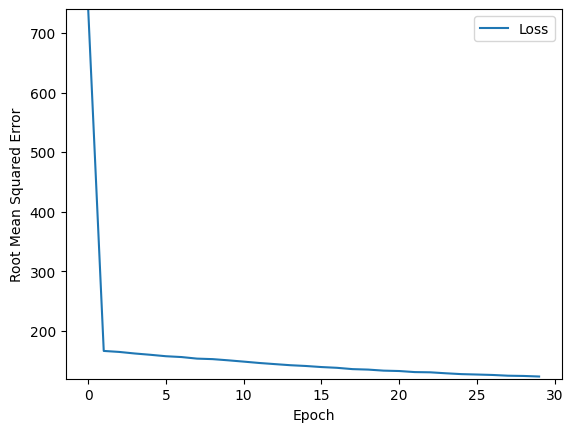

In [ ]:
# Las siguientes variables representan a los hyperparámetros
learning_rate = 0.01
epochs = 30
batch_size = 30

# Especificamos la característica y la etiqueta
my_feature = "total_rooms" # el número total de cuartos en un bloque especifico de la ciudad.
my_label = "median_house_value" # el valor medio de una casa en un bloque especifico de la ciudad.
# Esto es vamos a crear un modelo que predice el valor de la casa basado en
# en el número total (total_rooms) de habitaciones.

# Desechamos cualquier modelo pre-existente.
my_model = None

# Invocamos las funciones
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

# Usamos el modelo para hacer predicciones

Puede usar el modelo entrenado para hacer predicciones. En la práctica, debe hacer predicciones sobre ejemplos que no se usan en el entrenamiento. Sin embargo, para este ejercicio, solo trabajará con un subconjunto del mismo conjunto de datos de entrenamiento. Un ejercicio posterior de Colab explorará formas de hacer predicciones sobre ejemplos que no se usan en el entrenamiento.

Primero, creamos y ejecutamos la siguiente función para la predicción de la casa:

In [ ]:
def predict_house_values(n, feature, label):
  """Predice el valor de las casas en base a la característica."""

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x = batch)

  print("feature    label           predicted")
  print("  value    value           value")
  print("           in thousand$    in thousand$")
  print("----------------------------------------")
  for i in range(n):
    print("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                  training_df[label][10000 + i],
                                  predicted_values[i][0]))

Ahora invocamos la función de la predicción para examinar 10 ejemplos:

In [ ]:
predict_house_values(10, my_feature, my_label)

feature    label           predicted
  value    value           value
           in thousand$    in thousand$
----------------------------------------
 1960     53             168
 3400     92             194
 3677     69             199
 2202     62             172
 2403     80             176
 5652    295             235
 3318    500             193
 2552    342             179
 1364    118             157
 3468    128             195


## TAREA 2: Juzguemos el valor predictivo de nuestro modelo

Mirar el la tabla anterior. Comó de cerca esta el valor predecido sobre el valor de la etiqueta (label)? En otras palabras, predice tu modelo de manera adecuada?

In [ ]:
#@title Respuesta:

# La mayoría de las predicciones difieren significativamente del valor
# de la etiqueta, así que el el modelo de entrenamiento no tiene mucha
# poder predictivo. De todos modos, los 10 primeros ejemplos podrían
# no ser representativos del resto de las muestras.

# TAREA 3: Prueba una característica distinta.

La característica `total_room` tiene un poder predictivo muy pobre. ¿Es posible que haya alguna otra característica con un poder predictivo mayor? Prueba con `population` como característica en vez de `total_rooms`.

Epoch 1/30
567/567 [==============================] - 2s 2ms/step - loss: 7846.2959 - root_mean_squared_error: 88.5793
Epoch 2/30
567/567 [==============================] - 1s 2ms/step - loss: 7062.3232 - root_mean_squared_error: 84.0376
Epoch 3/30
567/567 [==============================] - 1s 2ms/step - loss: 7059.8105 - root_mean_squared_error: 84.0227
Epoch 4/30
567/567 [==============================] - 1s 2ms/step - loss: 7066.0703 - root_mean_squared_error: 84.0599
Epoch 5/30
567/567 [==============================] - 1s 2ms/step - loss: 7051.1670 - root_mean_squared_error: 83.9712
Epoch 6/30
567/567 [==============================] - 1s 2ms/step - loss: 7050.5625 - root_mean_squared_error: 83.9676
Epoch 7/30
567/567 [==============================] - 1s 1ms/step - loss: 7066.4385 - root_mean_squared_error: 84.0621
Epoch 8/30
567/567 [==============================] - 1s 1ms/step - loss: 7060.7207 - root_mean_squared_error: 84.0281
Epoch 9/30
567/567 [============================

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


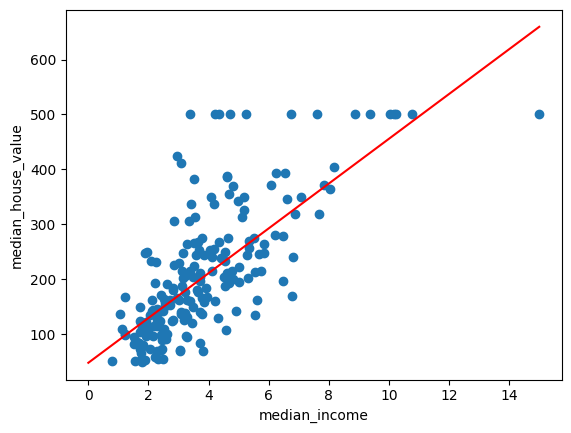

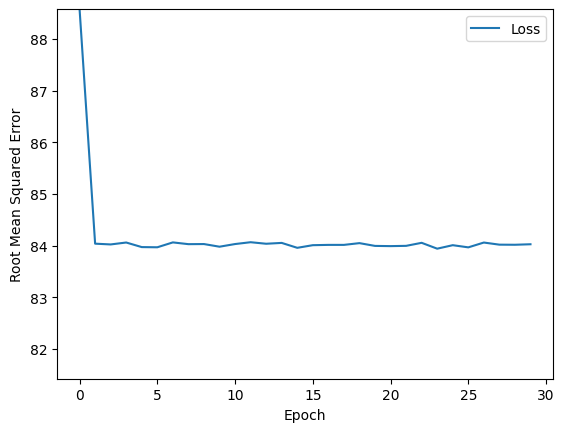

feature    label           predicted
  value    value           value
           in thousand$    in thousand$
----------------------------------------
    2     53             136
    4     92             211
    3     69             155
    2     62             134
    3     80             155
    2    295             149
   10    500             447
    5    342             257
    2    118             148
    4    128             220
    8    187             389
    3     80             164
    3    112             179
    4     95             220
    2     69             145


In [ ]:
my_feature = "median_income"

# hiperparámetros
learning_rate = 1
epochs = 30
batch_size = 30

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

# TAREA 4: Definir una característica sintética

Hemos visto que `total_rooms`y `population` no fueron de mucha ayuda. Esto es, ni el número total de habitaciones en un barrio, ni la populación de un barrio fueron capaces de hacer una predicción satisfactoria del valor medio de la casa en dicho barrio. Sin embargo, tal vez, la relación entre el total de habitaciones y la población podría tener algún poder predictivo. Es decir, quizás la densidad de bloques se relacione con el valor medio de la vivienda.

Para explorar esta hipótesis, haz lo siguiente:

  1. Crea una característica sintética que sea una porción de `total_rooms`y `population`.

  2. Afina los parámetros.

  3. Determina de si esta característica sintétitca produce un valor menor que cualquiera de las características que probaste anteriormente.

Epoch 1/24
567/567 [==============================] - 1s 2ms/step - loss: 37489.6133 - root_mean_squared_error: 193.6223
Epoch 2/24
567/567 [==============================] - 1s 2ms/step - loss: 18871.6094 - root_mean_squared_error: 137.3740
Epoch 3/24
567/567 [==============================] - 1s 2ms/step - loss: 15138.0322 - root_mean_squared_error: 123.0367
Epoch 4/24
567/567 [==============================] - 1s 2ms/step - loss: 14821.8428 - root_mean_squared_error: 121.7450
Epoch 5/24
567/567 [==============================] - 1s 2ms/step - loss: 14610.1445 - root_mean_squared_error: 120.8724
Epoch 6/24
567/567 [==============================] - 1s 2ms/step - loss: 14437.6348 - root_mean_squared_error: 120.1567
Epoch 7/24
567/567 [==============================] - 1s 2ms/step - loss: 14242.7754 - root_mean_squared_error: 119.3431
Epoch 8/24
567/567 [==============================] - 1s 1ms/step - loss: 14139.9629 - root_mean_squared_error: 118.9116
Epoch 9/24
567/567 [============

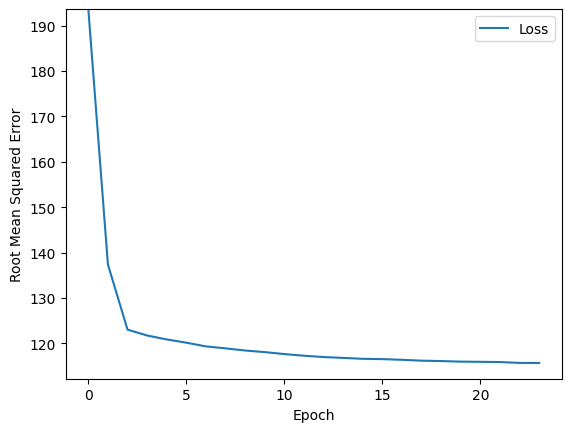

feature    label           predicted
  value    value           value
           in thousand$    in thousand$
----------------------------------------
    2     53             188
    2     92             200
    2     69             194
    2     62             211
    1     80             186
    2    295             224
    2    500             210
    2    342             222
    4    118             286
    2    128             213
    2    187             223
    3     80             233
    2    112             224
    2     95             218
    2     69             210


In [ ]:
# Definimos una característica sintética llamada rooms_per_person
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]

my_feature = "rooms_per_person"

# Hyperparámetros
learning_rate = 0.06
epochs = 24
batch_size = 30

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

En función de los valores de pérdida, esta característica sintética produce un mejor modelo que las características individuales que probó en la Tarea 2 y la Tarea 3. Sin embargo, el modelo aún no genera grandes predicciones.

# TAREA 5: Encuentrar características cuyos calores sin procesar se correlacionen con la etiqueta.

Una matriz de correlación indica cómo se relacionan los valores brutos de cada atributo con los valores brutos de los otros atributos. Los valores de correlación tienen los siguientes significados:

  • 1,0: correlación positiva perfecta; es decir, cuando un atributo sube, el otro atributo sube.

  • -1,0: correlación negativa perfecta; es decir, cuando un atributo sube, el otro atributo cae.

  • 0,0: sin correlación; las dos columnas no están linealmente relacionadas.

In [ ]:
# Generamos una matriz de correlación
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


**Tu tarea:** Determina cual de las 9 características parecen ser las mejores candidátas para ser características.

In [ ]:
#@title Respuesta:

# median_income tiene una realción con median_house_value de 0.7,
# así que median_income puede ser una buena característica. Las otras
# 8 potenciales características tienen una correlación relativa
# cercana a 0.

# Si el tiempo te lo permite, prueba median_income como característica
# y observa si el modelo mejora.